In [1]:
%pip install matplotlib networkx pymupdf



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import networkx as nx
import fitz  # PyMuPDF
import re

# Define the directory containing PDF SOPs
sop_dir = r"C:\Users\dharris\Downloads\ISC Owned QMS"  # Change this to the actual path

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text("text") + "\n"
    return text
    print(text) 

# Function to extract SOP references (first instance is the title, others are relationships)
def extract_references(text):
    pattern = re.compile(r"\b(JV-QDOC-\d{6})\b")  # Updated regex for format JV-QDOC-XXXXXX
    matches = pattern.findall(text)
    if not matches:
        return None, []  # No matches found
    
    # Filter out JV-QDOC-003254 from matches
    filtered_matches = [match for match in matches if match != "JV-QDOC-003254"]
    
    if not filtered_matches:  # If all matches were filtered out
        return None, []
        
    sop_title = filtered_matches[0]  # The first match is the title (current SOP)
    references = [ref for ref in filtered_matches[1:] if ref != sop_title]  # Remove self-referencing
    return sop_title, references

# Initialize an empty graph
sop_graph = nx.DiGraph()

# Dictionary to store SOP file paths (keyed by detected SOP name)
sop_files = {}

# Process all SOP PDFs
for file in os.listdir(sop_dir):
    if file.endswith(".pdf"):
        pdf_path = os.path.join(sop_dir, file)
        sop_text = extract_text_from_pdf(pdf_path)
        sop_title, references = extract_references(sop_text)
        
        if sop_title:  # Ensure valid title extracted
            sop_files[sop_title] = pdf_path  # Store file reference
            sop_graph.add_node(sop_title)  # Add as a node

            # Add directed edges for references (excluding self-references)
            for ref in references:
                if ref != sop_title:  # Prevent self-referencing edges
                    sop_graph.add_edge(sop_title, ref)

print("SOP Graph created with", len(sop_graph.nodes), "nodes and", len(sop_graph.edges), "edges.")




SOP Graph created with 95 nodes and 192 edges.


In [2]:
sop_text

' \nSTANDARD OPERATING PROCEDURE \nDocument Number \nJV-QDOC-006590 \nName \nValidation Planning and Reporting of Computerised \nSystems \nVersion \n2.0 \n \nPage 1 of 7 \n \nTable of Contents \nTable of Contents .................................................................................................................. 1 \n1. Purpose ............................................................................................................................ 2 \n2. Scope ............................................................................................................................... 2 \n3. Roles ................................................................................................................................ 2 \n4. Definitions / Abbreviations ................................................................................................ 3 \n5. Process Flow .................................................................................................

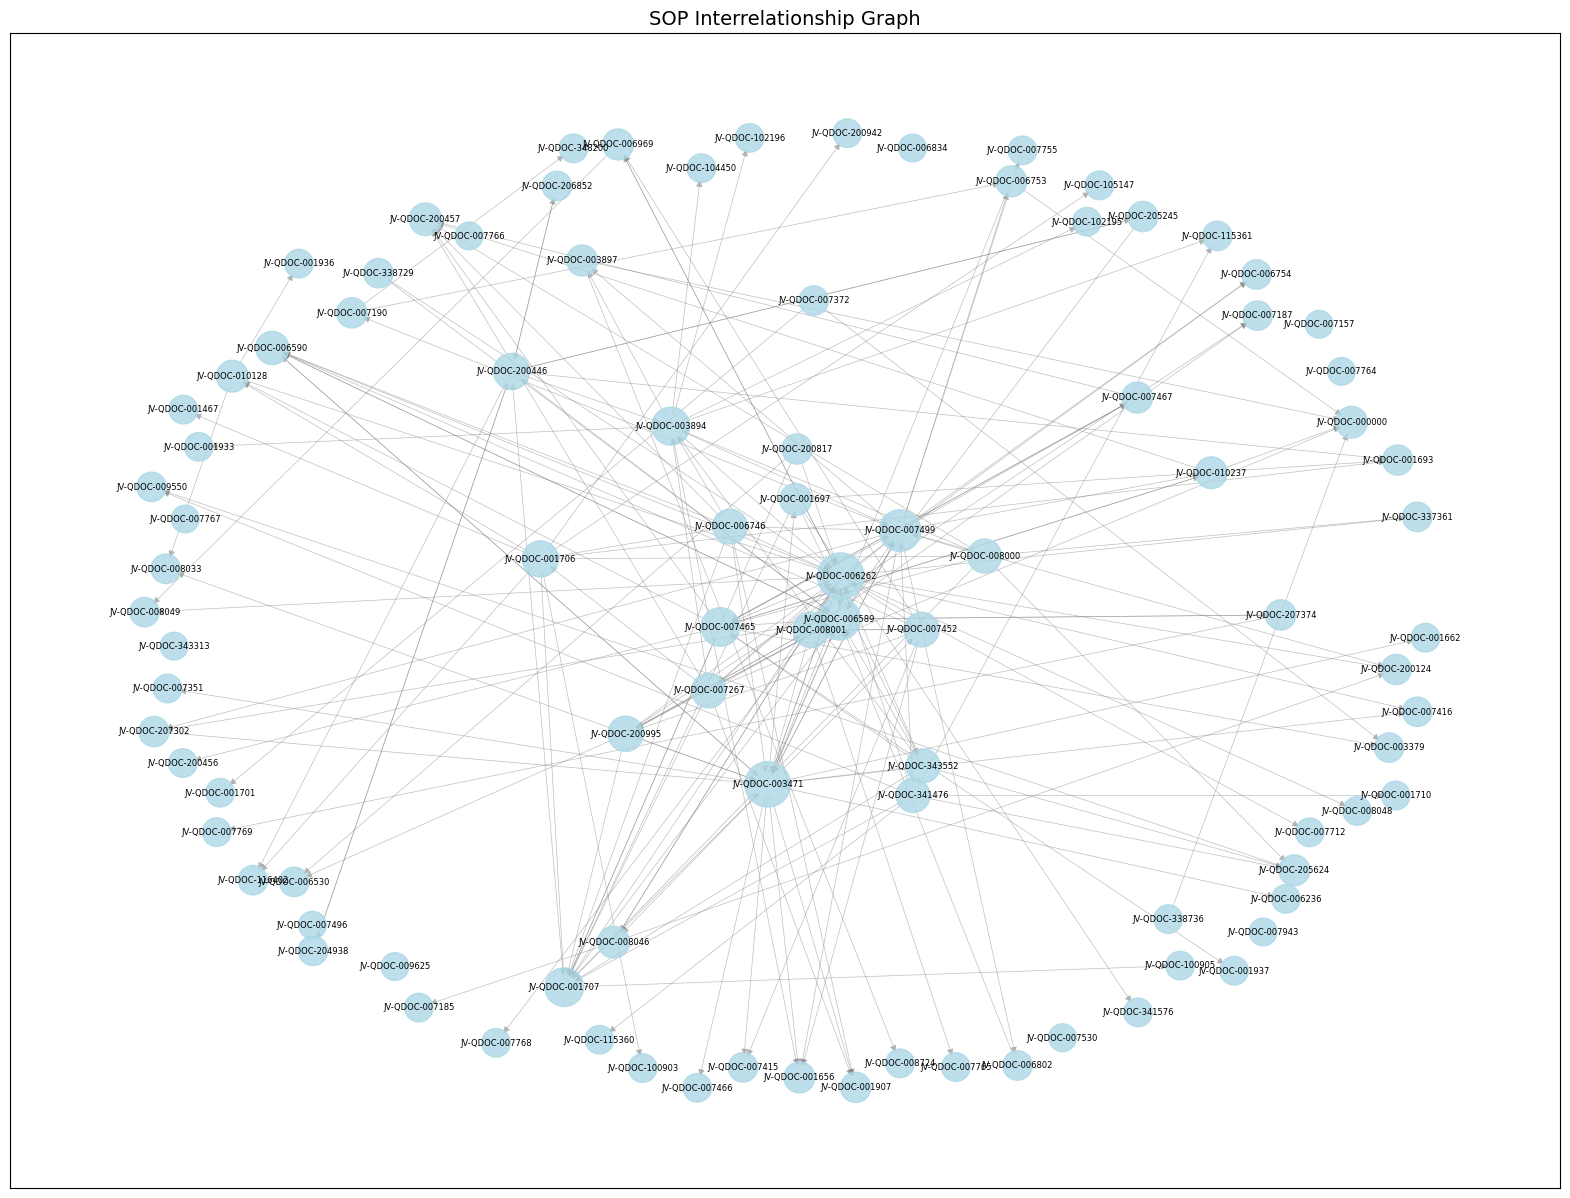

In [24]:
plt.figure(figsize=(20, 15))

# Use spring layout with adjusted parameters for better spacing
pos = nx.spring_layout(sop_graph, k=2, iterations=100)  

# Adjust node sizes to be smaller overall
node_sizes = [400 + 25 * sop_graph.degree(n) for n in sop_graph.nodes]

# Draw nodes with smaller size
nx.draw_networkx_nodes(sop_graph, pos, node_color="lightblue", node_size=node_sizes, alpha=0.8)

# Draw edges with thinner lines
nx.draw_networkx_edges(sop_graph, pos, edge_color="gray", alpha=0.5, width=0.5, arrows=True)

# Identify and label all nodes but with smaller font
labels = {sop: sop for sop in sop_graph.nodes()}
nx.draw_networkx_labels(sop_graph, pos, labels=labels, font_size=6)

plt.title("SOP Interrelationship Graph", fontsize=14)
plt.show()